# CNN 图像分类

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms


print(torch.__version__)


1.5.0+cpu


首先定义一个基于ConvNet的简单神经网络

常见的ConvNet架构
------------
Input -> [[conv ->relu] * N -> pool] * M -> [FC -> relu] * K


NLL loss的定义

$$
\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad
        l_n = - w_{y_n} x_{n,y_n}, \quad
        w_{c} = \text{weight}[c] \cdot \mathbb{1}\{c \not= ignore \_index \}
$$

In [18]:
# 这个是我定义的CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )  
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )
        self.fc = nn.Sequential(
            nn.Linear(4*4*50, 500),
            nn.ReLU(),
            nn.Linear(500, 10)
        )
        
    def forward(self, x):
        x = self.conv1(x)  # (28*28)->(24*24) ->(12*12)
        x = self.conv2(x)  # (12*12)->(8*8) ->(4*4)*50
        x = x.view(-1, 4*4*50)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [29]:
torch.random.manual_seed(10)
net_cnn = CNN()
x = torch.rand(3, 1, 28, 28)
print(x.size())
y = net_cnn(x)
print(y[0])

torch.Size([3, 1, 28, 28])
tensor([-2.3540, -2.3172, -2.2637, -2.3495, -2.2770, -2.3919, -2.2543, -2.3741,
        -2.2499, -2.2111], grad_fn=<SelectBackward>)


In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)  # 28*28 -> (28+1-5)  24*24
        self.conv2 = nn.Conv2d(20, 50, 5, 1) # 20*20 
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10) # 线性层
        
    def forward(self, x):
        # x: 1*28*28
        x = F.relu(self.conv1(x))  # 20*24*24
        x = F.max_pool2d(x, 2, 2)  # 20*12*12
        x = F.relu(self.conv2(x))  # 50*8*8
        x = F.max_pool2d(x, 2, 2)  # 50*4*4
        x = x.view(-1, 4*4*50)  # reshape (5 * 2 * 10), 
        x = F.relu(self.fc1(x)) # 1* (4*4*50)
        x = self.fc2(x)
        # return x
        return F.log_softmax(x, dim=1)  # log probability
    

In [38]:
mnist_data = datasets.MNIST("./mnist_data", train=True, download=False, transform=transforms.ToTensor())


In [104]:
type(mnist_data[3])

tuple

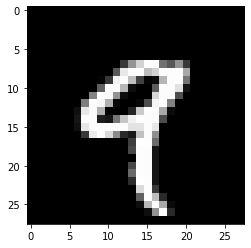

In [105]:
plt.imshow(mnist_data[4][0][0], plt.cm.gray)

In [48]:
def train(model, device, train_loader, optimizer, epoch, log_interval=100):
    # model, device, train_loader, optimizer, epoch
    model.train()
    for idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        pred = model(data) # batch_size * 10
        loss = F.nll_loss(pred, target)
        
        # SGD
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if idx % log_interval == 0:
            print("Train Epoch: {}, iteration: {}, Loss: {}".format(
                epoch, idx, loss.item()))


In [49]:
def test(model, device, test_loader):
    # model, device, test_loader
    model.eval() # 测试模式
    total_loss = 0.
    correct = 0.
    with torch.no_grad():
        for idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data) #batch_size * 10
            total_loss += F.nll_loss(output, target, reduction="sum").item() # .item() one element tensors can be converted to Python scalars
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    total_loss /= len(test_loader.dataset)
    print("Test Loss: {}, Accuracy: {}".format(total_loss, correct/len(test_loader.dataset) * 100.))

In [50]:
my_list = ['apple', 'banana', 'grapes', 'pear']
for c, value in enumerate(my_list):
    print(c, value)

0 apple
1 banana
2 grapes
3 pear


In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('./mnist_data', train=True, download=True,
                  transform=transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize((0.1307,), (0.3081,)) # mean and std
                  ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('./mnist_data', train=False, download=True,
                  transform=transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize((0.1307,), (0.3081,))
                  ])),
    batch_size=batch_size, shuffle=True, **kwargs)

# 参数
lr = 0.01
momentum = 0.5
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

num_epochs = 2
for epoch in range(1, num_epochs+1):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

save_model = False
if (save_model):
    torch.save(model.state_dict(),"mnist_cnn.pt")

Train Epoch: 1, iteration: 0, Loss: 2.3073532581329346
Train Epoch: 1, iteration: 100, Loss: 0.5852776169776917
Train Epoch: 1, iteration: 200, Loss: 0.3255491554737091
Train Epoch: 1, iteration: 300, Loss: 0.26051682233810425
Train Epoch: 1, iteration: 400, Loss: 0.09202799946069717
Train Epoch: 1, iteration: 500, Loss: 0.2725370526313782
Train Epoch: 1, iteration: 600, Loss: 0.0486789233982563
Train Epoch: 1, iteration: 700, Loss: 0.05373590812087059
Train Epoch: 1, iteration: 800, Loss: 0.10580065846443176
Train Epoch: 1, iteration: 900, Loss: 0.13047051429748535
Train Epoch: 1, iteration: 1000, Loss: 0.05118386819958687
Train Epoch: 1, iteration: 1100, Loss: 0.06701096892356873
Train Epoch: 1, iteration: 1200, Loss: 0.054701805114746094
Train Epoch: 1, iteration: 1300, Loss: 0.04060843214392662
Train Epoch: 1, iteration: 1400, Loss: 0.03431890159845352
Train Epoch: 1, iteration: 1500, Loss: 0.14673297107219696
Train Epoch: 1, iteration: 1600, Loss: 0.02050640806555748
Train Epoch: 

# CNN模型的迁移学习

- 很多时候当我们需要训练一个新的图像分类任务，我们不会完全从一个随机的模型开始训练，而是利用_预训练_的模型来加速训练的过程。我们经常使用在`ImageNet`上的预训练模型。
- 这是一种transfer learning的方法。我们常用以下两种方法做迁移学习。
    - fine tuning: 从一个预训练模型开始，我们改变一些模型的架构，然后继续训练整个模型的参数。
    - feature extraction: 我们不再改变与训练模型的参数，而是只更新我们改变过的部分模型参数。我们之所以叫它feature extraction是因为我们把预训练的CNN模型当做一个特征提取模型，利用提取出来的特征做来完成我们的训练任务。
    
以下是构建和训练迁移学习模型的基本步骤：
- 初始化预训练模型
- **把最后一层的输出层改变成我们想要分的类别总数**
- 定义一个optimizer来更新参数
- 模型训练

In [15]:
import numpy as np
import torchvision
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
import time
import os
import copy
# print("Torchvision Version: ",torchvision.__version__)

数据
------

我们会使用*hymenoptera_data*数据集，[下载](https://download.pytorch.org/tutorial/hymenoptera_data.zip).

这个数据集包括两类图片, **bees** 和 **ants**, 这些数据都被处理成了可以使用[`ImageFolder `]https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder 来读取的格式。我们只需要把``data_dir``设置成数据的根目录，然后把``model_name``设置成我们想要使用的与训练模型：
::
   [resnet, alexnet, vgg, squeezenet, densenet, inception]

其他的参数有：
- ``num_classes``表示数据集分类的类别数
- ``batch_size``
- ``num_epochs``
- ``feature_extract``表示我们训练的时候使用fine tuning还是feature extraction方法。如果``feature_extract = False``，整个模型都会被同时更新。如果``feature_extract = True``，只有模型的最后一层被更新。

In [16]:
# Top level data directory. Here we assume the format of the directory conforms 
#   to the ImageFolder structure
data_dir = "../data/hymenoptera_data"
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"
# Number of classes in the dataset
num_classes = 2
# Batch size for training (change depending on how much memory you have)
batch_size = 32
# Number of epochs to train for 
num_epochs = 15
# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = True

In [25]:
# 设置是否记录梯度
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [26]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    if model_name == "resnet":
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract) 
        # 设置全连接层
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    return model_ft, input_size
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [32]:
model_ft.layer1[0].conv1.weight.requires_grad

False

In [33]:
model_ft.fc.weight.requires_grad

True

In [45]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=5):
    since = time.time()
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs-1))
        print("-"*10)
        
        for phase in ["train", "val"]:
            running_loss = 0.
            running_corrects = 0.
            if phase == "train":
                model.train()
            else: 
                model.eval()
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                with torch.autograd.set_grad_enabled(phase=="train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                _, preds = torch.max(outputs, 1)
                if phase == "train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds.view(-1) == labels.view(-1)).item()
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
       
            print("{} Loss: {} Acc: {}".format(phase, epoch_loss, epoch_acc))
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "val":
                val_acc_history.append(epoch_acc)
            
        print()
    
    time_elapsed = time.time() - since
    print("Training compete in {}m {}s".format(time_elapsed // 60, time_elapsed % 60))
    print("Best val Acc: {}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

## 读入数据

已知模型输入的size，我们可以把数据处理成相应的格式

In [18]:
input_size = 224

all_imgs = datasets.ImageFolder(os.path.join(data_dir, "train"), transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(), # 随机水平翻转
    transforms.ToTensor(),
]))

loader = torch.utils.data.DataLoader(all_imgs, batch_size=batch_size, shuffle=True, num_workers=4)

In [19]:
img = next(iter(loader))[0]

In [34]:
img.shape

torch.Size([32, 3, 224, 224])

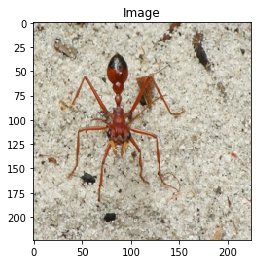

In [23]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(img[7], title='Image')


In [38]:
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # mean, std
    ]),
    "val": transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloader
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


## Gather the parrameters

In [46]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parrameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 fc.weight
	 fc.bias


In [47]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, ohist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/14
----------


KeyboardInterrupt: 

In [ ]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs)


In [ ]:

# Plot the training curves of validation accuracy vs. number 
#  of training epochs for the transfer learning method and
#  the model trained from scratch
# ohist = []
# shist = []

# ohist = [h.cpu().numpy() for h in ohist]
# shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),scratch_hist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()